# Training and evaluation of the comments model

This notebook contains the training of the model to classify a comment in the platform as positive or negative. It also contains a section where the model performance is evaluated.

- Created by: Juan Fernandez
- Created on: 2/Jan/2019
- Modified by: William Alexander
- Meidifed on: 16/March/2019

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

from dotenv import load_dotenv, find_dotenv
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pipeline import make_ds_flow_pipeline
from preprocessing import create_dataset, get_labeled_comments, get_token_weigths

In [4]:
COMMENTS_URL = 'https://jsonplaceholder.typicode.com/comments'

In [5]:
load_dotenv(find_dotenv(), verbose=True)

usr = os.getenv('DB_USERNAME')
pwd = os.getenv('DB_PASSWORD')
token = os.getenv('DB_TOKEN')

if not(usr and pwd and token):
    raise Exception('Credentials are missing')

### Data preprocessing

In [6]:
comments = get_labeled_comments(COMMENTS_URL, usr, pwd, token)
comments.head()

,body,email,name,postId,sentiment
0,laudantium enim quasi est quidem magnam volupt...,Eliseo@gardner.biz,id labore ex et quam laborum,1,0
1,est natus enim nihil est dolore omnis voluptat...,Jayne_Kuhic@sydney.com,quo vero reiciendis velit similique earum,1,1
2,quia molestiae reprehenderit quasi aspernatur\...,Nikita@garfield.biz,odio adipisci rerum aut animi,1,1
3,non et atque\noccaecati deserunt quas accusant...,Lew@alysha.tv,alias odio sit,1,0
4,harum non quasi et ratione\ntempore iure ex vo...,Hayden@althea.biz,vero eaque aliquid doloribus et culpa,1,1


In [7]:
weights = get_token_weigths('token_weights.csv')
weights.head()

,token,weight
0,pa,0.388042
1,er,0.828243
2,x,0.476935
3,or,0.387840
4,a,0.485616


In [8]:
comments = create_dataset(comments, weights)
comments.head()

,body,email,name,postId,sentiment,weights
0,laudantium enim quasi est quidem magnam volupt...,Eliseo@gardner.biz,id labore ex et quam laborum,1,0,1
1,est natus enim nihil est dolore omnis voluptat...,Jayne_Kuhic@sydney.com,quo vero reiciendis velit similique earum,1,1,1
2,quia molestiae reprehenderit quasi aspernatur\...,Nikita@garfield.biz,odio adipisci rerum aut animi,1,1,1
3,non et atque\noccaecati deserunt quas accusant...,Lew@alysha.tv,alias odio sit,1,0,1
4,harum non quasi et ratione\ntempore iure ex vo...,Hayden@althea.biz,vero eaque aliquid doloribus et culpa,1,1,1


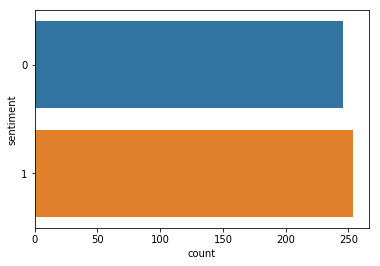

In [9]:
sns.countplot(y='sentiment', data=comments);

In [10]:
X_train, X_test, y_train, y_test = train_test_split(comments[['body', 'weights']], comments['sentiment'])
weights = X_train['weights']
X_train = X_train['body']
X_test = X_test['body']

### Feature engineering

In [11]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X_train)
print('Sparsity:', (np.prod(X.shape) - X.count_nonzero()) / np.prod(X.shape))

Sparsity: 0.8789686924493554


### Training

In [12]:
forest = RandomForestClassifier(random_state=21)
forest = forest.fit(X, y_train, sample_weight=weights)

/home/rodrigo/anaconda3/envs/ds-flow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### Evaluation

In [13]:
accuracy_score(y_test, forest.predict(vectorizer.transform(X_test)))

0.512

### Comparison with model from scripts

In [14]:
model_pipeline = make_ds_flow_pipeline(seed=21)
model_pipeline = model_pipeline.fit(X_train, y_train, forest__sample_weight=weights)
accuracy_score(y_test, model_pipeline.predict(X_test))

/home/rodrigo/anaconda3/envs/ds-flow/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.512